# Notebook 1: The first simulation

This noteboook covers the very basics of setting up a finite difference frequency domain (FDFD) simulation in `ceviche`.

In [1]:
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import matplotlib.pylab as plt

import ceviche

## The simplest example: a line source above a dielectric 

In [2]:
# Source angular frequency in Hz
omega = 2*np.pi*200e12

# Resolution in nm
dl = 25e-9

# Simulation domain size in number of pixels
Nx = 100
Ny = 100

# Size of the PML boundaries in pixels 
Npml = 20

In [3]:
# Initialize relative permittivity of the domain
epsr = np.ones((Nx, Ny))  
# Set the permittivity to 12 inside a box
epsr[0:50,0:50] = 12

# Initialize the source position and amplitude
src_x = np.arange(40,60)
src_y = 70 * np.ones(src_x.shape, dtype=int)
source = np.zeros((Nx, Ny), dtype=np.complex) 
source[src_x, src_y] = 1

In [4]:
# Create the simulation object for 'Ez' (TE) polarization
simulation = ceviche.fdfd_ez(omega, dl, epsr, [Npml, Npml])
# Run the simulation with the given source
Hx, Hy, Ez = simulation.solve(source)

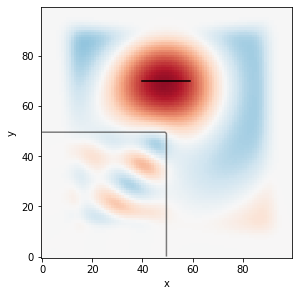

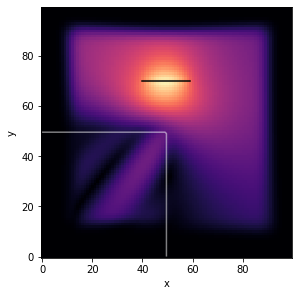

In [5]:
# Visualize the real value of the Ez field component
ax = ceviche.viz.real(Ez, outline=epsr, cbar=False)
# Plot the source position
ax.plot(src_x,src_y,'k')

# Absolute value of the Ez field
ax = ceviche.viz.abs(Ez, outline=epsr, cbar=False)
# Source
ax.plot(src_x,src_y,'k')

plt.show()

## A simple example: a waveguide

In [6]:
# Define simulation parameters (see above)
omega = 2*np.pi*200e12
dl = 25e-9

Nx = 200
Ny = 80
Npml = 20

# Define permittivity for a straight waveguide
epsr = np.ones((Nx, Ny))  
epsr[:,35:45] = 12

In [7]:
# Source position and amplitude
src_y = np.arange(20,60)
src_x = 30 * np.ones(src_y.shape, dtype=int)
source = ceviche.modes.insert_mode(omega, dl, src_x, src_y, epsr)

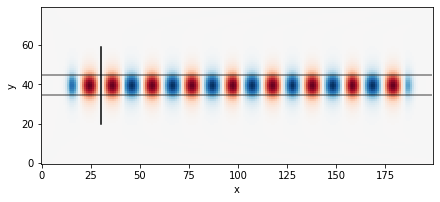

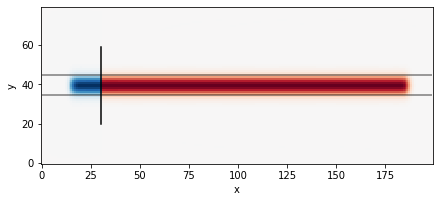

In [8]:
# Run the simulation for Ez polarization
simulation = ceviche.fdfd_ez(omega, dl, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source)

# Visualize the electric field
ax = ceviche.viz.real(Ez, outline=epsr, cmap='RdBu_r')
ax.plot(src_x,src_y,'k')

# Compute the Poynting vector that shows the direction and magnitude of the transferred power
Sx = -0.5 * np.real(Ez * np.conj(Hy))
Sy =  0.5 * np.real(Ez * np.conj(Hx))

# Show the Poynting vector in the x-direction: note the guided power propagation
ax = ceviche.viz.real(Sx, outline=epsr, cmap='RdBu_r')
ax.plot(src_x,src_y,'k')

plt.show()

## A ring
Next, we simulate a ring resonator side-coupled to a waveguide

In [9]:
# Simulation parameters
omega = 2*np.pi*200e12
dl = 25e-9

Nx = 200
Ny = 180
Npml = 20

# Permittivity for the waveguide
epsr = np.ones((Nx, Ny))  
epsr[:,35:45] = 12

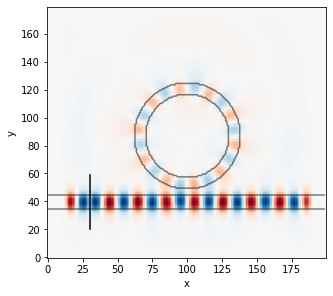

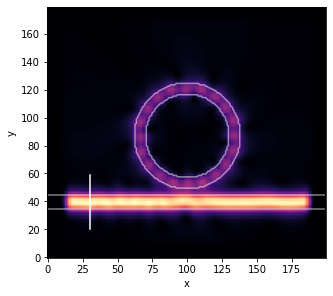

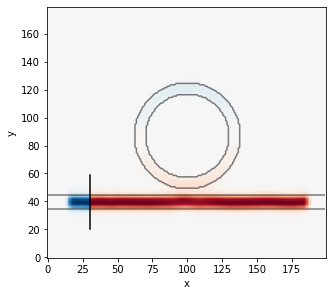

In [12]:
# We use a helpful Scikit tool to draw the ring permittivity
from skimage.draw import circle

rr, cc = circle(100, 87, 38)
epsr[rr,cc] = 12
rr, cc = circle(100, 87, 30)
epsr[rr,cc] = 1

# Create a source in the waveguide
src_y = np.arange(20,60)
src_x = 30 * np.ones(src_y.shape, dtype=int)
source = ceviche.modes.insert_mode(omega, dl, src_x, src_y, epsr)

# Run the simulations
simulation = ceviche.fdfd_ez(omega, dl, epsr, [Npml, Npml])
Hx, Hy, Ez = simulation.solve(source)

# Visualize the field and source
ax = ceviche.viz.real(Ez, outline=epsr, cbar=False, cmap='RdBu_r')
ax.plot(src_x,src_y,'k')

# Visualize the absolute value of the field
ax = ceviche.viz.abs(Ez, outline=epsr, cbar=False)
ax.plot(src_x,src_y,'w')

# Visualize the Poynting vector in the x-direction
Sx = -0.5 * np.real(Ez * np.conj(Hy))
Sy =  0.5 * np.real(Ez * np.conj(Hx))
ax = ceviche.viz.real(Sx, outline=epsr, cbar=False, cmap='RdBu_r')
ax.plot(src_x,src_y,'k')

plt.show()